In [3]:
# internal imports

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

import sys, os
sys.path.insert(0, os.path.abspath('..'))
from src.data import dimensionality_reduction as dr

In [4]:
import pandas as pd
import numpy as np
from typing import List
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm import tqdm

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from scipy.sparse import csr_matrix

In [6]:
df = pd.read_csv("../data/interim/user_track_df.csv", index_col=[0])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 590 entries, user_000001 to user_001000
Columns: 178423 entries, ! Www.Polskie-Mp3.Tk ! Jacek Kaczmarski, Gintrowski And Lapinski_05. Astrolog to Ｄｊ　Ｋａｗａｓａｋｉ_Ｌｉｋｅ　Ｔｈｕｎｄｅｒ
dtypes: int64(178423)
memory usage: 803.1+ MB


<AxesSubplot:ylabel='Count'>

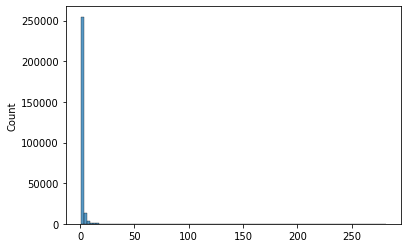

In [175]:
track_listened_list = df.to_numpy().reshape(1, -1)
listened_times = track_listened_list[track_listened_list>0]
sn.histplot(listened_times, bins=100)

The distribution is heavily right skewed. Most of the songs were only listened once.

# Truncated SVD

In [117]:
# Standardize the feature matrix
# TODO: not sure if standardizing is right preprocessing here
X = StandardScaler().fit_transform(df)

# Make sparse matrix
X_sparse = csr_matrix(X)

# Create a TSVD
tsvd = TruncatedSVD(n_components=100, random_state=42)

# Conduct TSVD on sparse matrix
X_sparse_tsvd = tsvd.fit(X_sparse).transform(X_sparse)

## 2D Scatter

In [9]:
# Create a TSVD
tsvd_2d = TruncatedSVD(n_components=2, random_state=42)

# Conduct TSVD on sparse matrix
X_sparse_tsvd_2d = tsvd_2d.fit(X_sparse).transform(X_sparse)

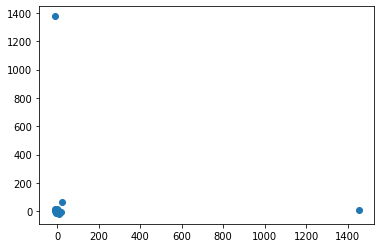

In [10]:
plt.scatter(X_sparse_tsvd_2d[:, 0], X_sparse_tsvd_2d[:, 1])

There are two obvious outliers. We can remove them and plot the scatter again.

In [11]:
outliers = np.where(X_sparse_tsvd_2d>200)[0]
df.index[outliers]

Index(['user_000068', 'user_000691'], dtype='object')

user_000068 and user_000691 may have a very different music taste so their representations in a lower space are so far away from the majority. We may explore the reason in a bit.

In [12]:
filterd_scatter = np.delete(X_sparse_tsvd_2d, np.where(X_sparse_tsvd_2d>200)[0], axis=0)

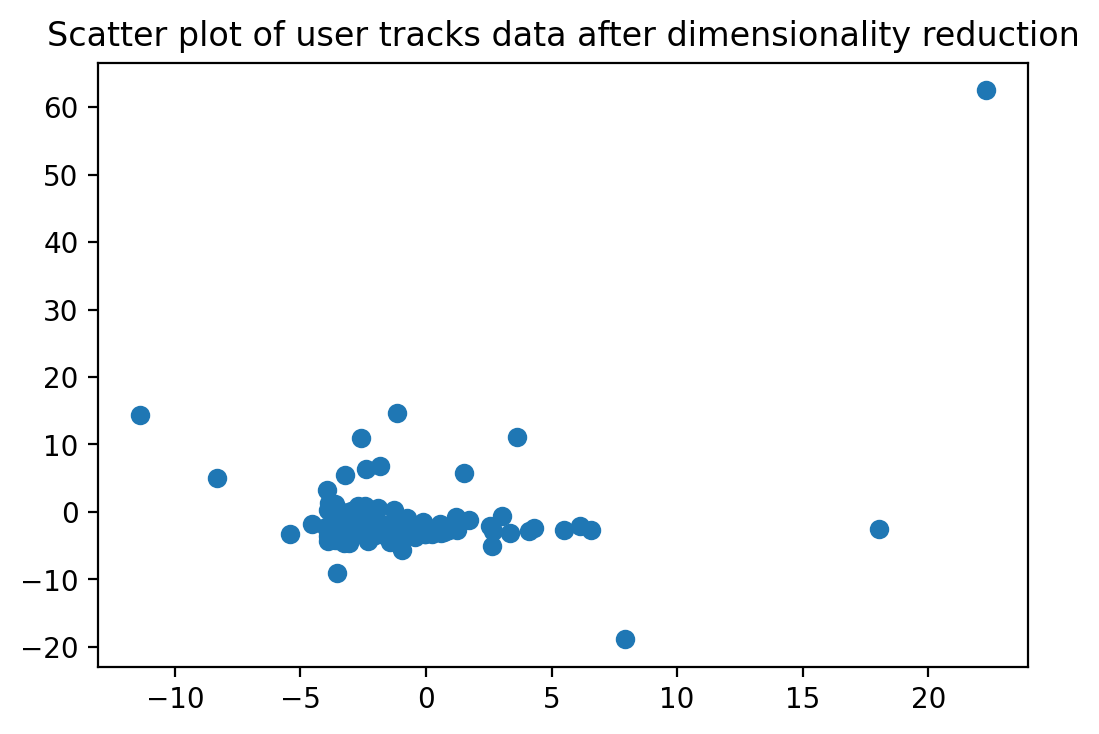

In [13]:
fig, ax = plt.subplots(dpi=200)
plt.scatter(filterd_scatter[:, 0], filterd_scatter[:, 1])
plt.title("Scatter plot of user tracks data after dimensionality reduction")
plt.show()

As we can see from the graph. There are no remarkable clusters.

# CUR

In [118]:
X_raw = df.to_numpy()

In [126]:
# try to find the n to minimize the reconstruction error
def find_n(X: np.ndarray) -> int:
    """
    Find the n to minimize the reconstruction error
    Args: 
        X: matrix to decompose
        n: number of rows/columns to sample
    Returns:
        n: number of rows/columns to sample
    """
    n = 0
    min_error = float("inf")
    for i in tqdm(range(2,20)):
        C, U, R = dr.cur(X, i, 99)
        e = np.sqrt(np.mean((X-C@U@R)**2))
        if e < min_error:
            min_error = e1
            n = i
    return n, min_error

In [189]:
find_n(X_raw)

100%|██████████| 18/18 [00:25<00:00,  1.42s/it]


(18, 0.17753600256631472)

In [190]:
np.sqrt(np.mean(X_raw**2))

0.17039052044964825

**Note that even when the reconstructed matrix is full of zeros, the error could be around 0.170. So the performance of CUR is not good as expected. I decide to not use it further.**

In [80]:
C, U, R = dr.cur(df.to_numpy(), 2, 41)
U.sum()


0.0

# Randomized SVD

In [194]:
U, S, V = randomized_svd(X_raw, n_components=2, random_state=0)

In [195]:
us_2d = U @ np.diag(S)

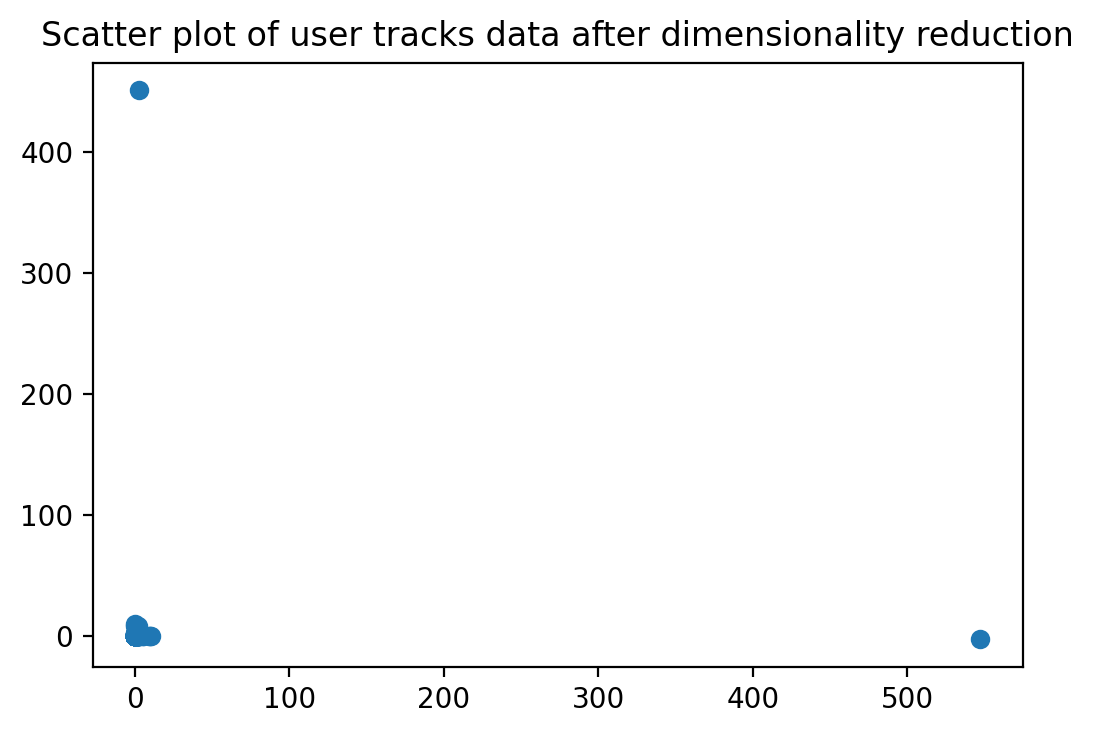

In [196]:
fig, ax = plt.subplots(dpi=200)
plt.scatter(us_2d[:, 0], us_2d[:, 1])
plt.title("Scatter plot of user tracks data after dimensionality reduction")
plt.show()

In [197]:
no_outlier = np.delete(u_s_2d, np.where(u_s_2d>200)[0], axis=0)

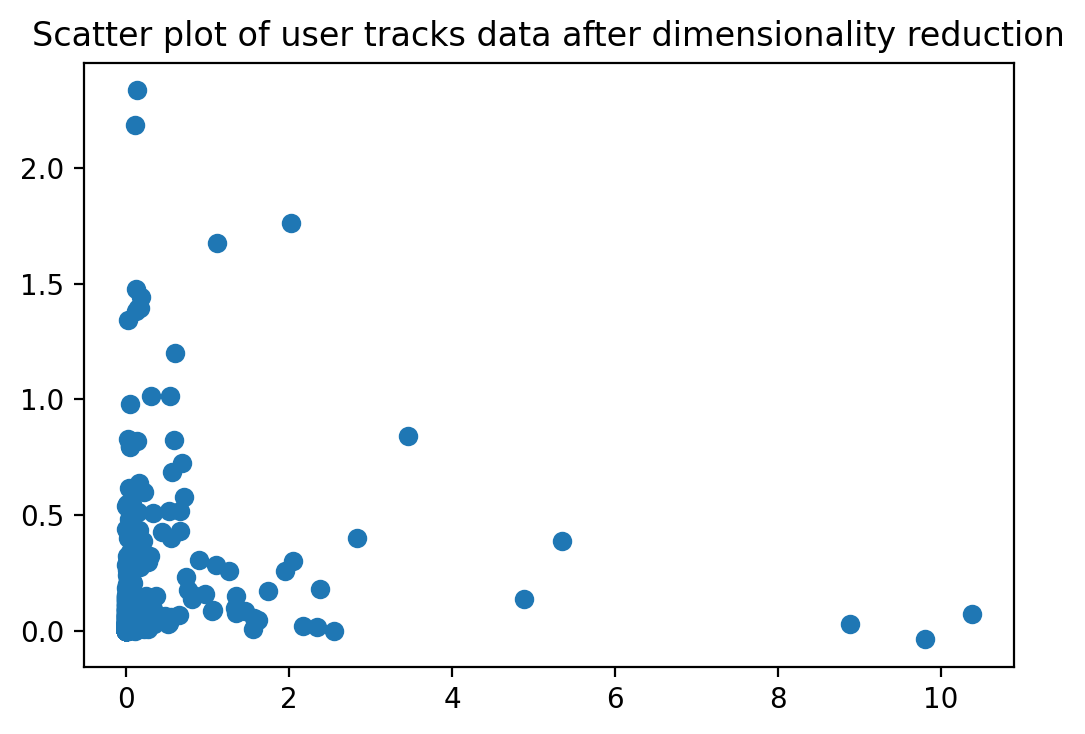

In [198]:
fig, ax = plt.subplots(dpi=200)
plt.scatter(no_outlier[:, 0], no_outlier[:, 1])
plt.title("Scatter plot of user tracks data after dimensionality reduction")
plt.show()

Let's check the reconstructed error

In [200]:
reconstructed_matrix = U @ np.diag(S) @ V
np.sqrt(np.mean((X_raw - reconstructed_matrix)**2))


0.15571850497965303

As we increase n, the reconstructed error is getting smaller.

0.15571850497965303
0.1464359130205582
0.1377867470034348
0.12617287566656427
0.1025791509474164
0.07869818466174881
0.0507054056698719
0.00589387239817326
3.316370832229839e-14


/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

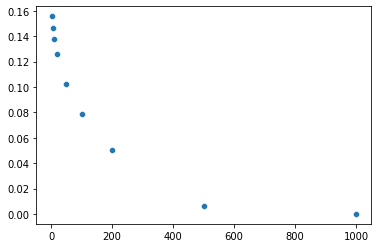

In [203]:
e_list = []
n_range = [2, 5, 10, 20, 50, 100, 200, 500, 1000]
for n in n_range:
    U, S, V = randomized_svd(X_raw, n_components=n, random_state=0)
    reconstructed_matrix = U @ np.diag(S) @ V
    e = np.sqrt(np.mean((X_raw - reconstructed_matrix)**2))
    e_list.append(e)
    print(e)
sn.scatterplot(n_range, e_list)


Let's pick 200 as these amount of components keep the most variance of the original data matrix.

In [204]:
U, S, V = randomized_svd(X_raw, n_components=200, random_state=0)
X_after_rd = U @ np.diag(S)

In [205]:
reduced_df = pd.DataFrame(X_after_rd, index=df.index, columns=[f"col_{i}" for i in range(200)])
reduced_df.to_csv("../data/processed/user_track_df_reduced.csv")